In [5]:
def traverse_left(colour, mask):
    coord = []
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if np.array_equal(mask[i][j], colour):
                coord.append([i, j])
                break
    return coord

def traverse_right(colour, mask):
    coord = []
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]-1, -1, -1):
            if np.array_equal(mask[i][j], colour):
                coord.append([i, j])
                break
    return coord

def extract_colored_inner_lining(color_mask):
    left_colors = [
        [255, 0, 0],     
        [0, 255, 0],     # Green
        [0, 0, 255],     # Red
    ]
    right_colors = [
        [255, 255, 0],  
        [255, 0, 255],   
        [0, 255, 255],  
    ]

    inner_lining_mask = np.zeros_like(color_mask)

    for i in left_colors:
        coord=traverse_right(i, color_mask)
        for x, y in coord:
            inner_lining_mask[x, y] = i

    for i in right_colors:
        coord=traverse_left(i, color_mask)
        for x, y in coord:
            inner_lining_mask[x, y] = i
    return inner_lining_mask


def Feature_extraction(video_path, model, device):
    segment_colors = [
        [255, 0, 0],     # Blue    - Left segment 1
        [0, 255, 0],     # Green   - Left segment 2
        [0, 0, 255],     # Red     - Left segment 3
        [255, 255, 0],   # Cyan    - Right segment 1
        [255, 0, 255],   # Magenta - Right segment 2
        [0, 255, 255],   # Yellow  - Right segment 3
    ]


   

    video_matrix =extract_mask_matrix_from_video(video_path, model, device)
    features_area = []
    features_boundary = []
    features_center = []

    area_ref=[]
    count1=0
    for frame in video_matrix:
        print(count1)
        count1+=1
        # print("Original shape:", frame.shape)
    
        # Normalize to [0, 255] range if not already
        # print(frame.shape)
        if(count1>27): 
            break
        if frame.max() <= 1.0:
            frame = (frame * 255).astype(np.uint8)

        color_mask = color_u_mask(frame)
    
        # plot_image(color_mask)
        points=get_segment_points(color_mask, segment_colors)
        if(len(area_ref)==0):
            area_ref=points
        # print(area_ref)
        intersection = set(map(tuple, points)) & set(map(tuple, area_ref))

        count = len(intersection)
        # print(points)
        features_area.append(count/len(area_ref))
        
        
        # break  # Only process one frame for now
    
    print(features_area)
    print(len(features_area))
    print(video_matrix.shape)
    return video_matrix



In [ ]:
# Data handling and processing
import pandas as pd
import numpy as np
import os

# Video processing
import cv2

# Deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Utility
from tqdm import tqdm
import matplotlib.pyplot as plt

class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        # number of input channels is a number of filters in the previous layer
        # number of output channels is a number of filters in the current layer
        # "same" convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch=1, output_ch=1):  # Changed img_ch to 1
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)
        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1)
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)
        return out

segmentation_model = AttentionUNet(img_ch=1, output_ch=1)


In [9]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights_path = '/kaggle/input/seg2/other/default/1/checkpoint_epoch_30.pth'  # Update with correct path
state_dict = torch.load(weights_path, map_location=device)

segmentation_model.load_state_dict(state_dict)
segmentation_model = segmentation_model.to(device)

# Set to evaluation mode
segmentation_model.eval()

print("Segmentation model weights loaded successfully.")

Segmentation model weights loaded successfully.


/tmp/ipykernel_31/172325405.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)


In [10]:
def color_segments_with_skip(coords_sorted, color_mask, colors):
    n_segments = len(colors)
    total_length = 0
    distances = [0]

    for i in range(1, len(coords_sorted)):
        prev = coords_sorted[i - 1]
        curr = coords_sorted[i]
        total_length += np.linalg.norm(curr - prev)
        distances.append(total_length)

    skip_len = 1.5 * total_length / 7
    usable_len = total_length - skip_len
    segment_len = usable_len / n_segments

    start_idx = 0
    while start_idx < len(distances) and distances[start_idx] < skip_len:
        start_idx += 1

    segments = [[] for _ in range(n_segments)]
    current_length = distances[start_idx]
    i = start_idx
    while i < len(distances) and current_length < total_length:
        segment_index = int((current_length - skip_len) // segment_len)
        if segment_index < n_segments:
            segments[segment_index].append(coords_sorted[i])
        current_length = distances[i]
        i += 1

    for seg_id, segment in enumerate(segments):
        for x, y in segment:
            color_mask[y, x] = colors[seg_id]

def color_u_mask(mask):
    #print(mask.shape)
    ys, xs = np.where(mask == 255)
    coords = np.column_stack((xs, ys))

    topmost_index = np.argmin(ys)
    x_center = xs[topmost_index]

    left_arm = coords[coords[:, 0] < x_center]
    right_arm = coords[coords[:, 0] > x_center]

    left_sorted = left_arm[np.argsort(left_arm[:, 1])]
    right_sorted = right_arm[np.argsort(right_arm[:, 1])]

    left_colors = [
        [255, 0, 0],     # Blue
        [0, 255, 0],     # Green
        [0, 0, 255],     # Red
    ]
    right_colors = [
        [255, 255, 0],   # Cyan
        [255, 0, 255],   # Magenta
        [0, 255, 255],   # Yellow
    ]

    color_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    color_segments_with_skip(left_sorted, color_mask, left_colors)
    color_segments_with_skip(right_sorted, color_mask, right_colors)

    return color_mask



In [12]:
def apply_clahe(frame):
    """Apply CLAHE to enhance contrast on a BGR frame."""
    lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    merged = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    return enhanced

def preprocess_frame_for_model(frame, size=(224, 224)):
    """Resize and convert a frame to grayscale for model input."""
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(frame_gray, size)  # Shape: [H, W]
    tensor = torch.from_numpy(resized).float().unsqueeze(0) / 255.0  # Shape: [1, H, W]
    return tensor.unsqueeze(0)  # Shape: [1, 1, H, W]

def extract_mask_matrix_from_video(video_path, model, device, frame_size=(224, 224)):

    cap = cv2.VideoCapture(video_path)
    mask_list = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_clahe = apply_clahe(frame)

        input_tensor = preprocess_frame_for_model(frame_clahe, size=frame_size).to(device)

        with torch.no_grad():
            pred_mask = model(input_tensor)  # Shape: [1, 1, H, W]
            
        binary_mask = (pred_mask.squeeze().cpu().numpy() > 0.5).astype(np.uint8)  # Shape: [H, W]
        mask_list.append(binary_mask)

    cap.release()

    mask_matrix = np.stack(mask_list, axis=0) 
    return mask_matrix


video_path = "/kaggle/input/myocardial-infarction/HMC-QU Dataset-Kaggle/HMC-QU/A4C/ES0001 _4CH_1.avi"
video_matrix = extract_mask_matrix_from_video(video_path, segmentation_model, device)
print("Video shape:", video_matrix.shape)  # (num_frames, height, width, 3)


Video shape: (41, 224, 224)


In [26]:
# import numpy as np
# # count1=0
# for frame in video_matrix:
#     # print(count1)
#     # count1+=1
#         # print("Original shape:", frame.shape)
    
#         # Normalize to [0, 255] range if not already
#         # print(frame.shape)
#     # if(count1>41): 
#     #     break
#     if frame.max() <= 1.0:
#         frame = (frame * 255).astype(np.uint8)
#         color_mask = color_u_mask(frame)
#     print("color_mask shape:", color_mask.shape)

In [25]:
# import numpy as np

# color_masks = []  # list to store each (224, 224, 3) color mask

# for frame in video_matrix:
#     if frame.max() <= 1.0:
#         frame = (frame * 255).astype(np.uint8)
    
#     color_mask = color_u_mask(frame)  # (224, 224, 3)
#     color_masks.append(color_mask)

# # Convert list to a NumPy array of shape (num_frames, 224, 224, 3)
# color_masks_array = np.stack(color_masks, axis=0)

# print("Final stacked shape:", color_masks_array.shape)

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
Final stacked shape: (41, 224, 224, 3)


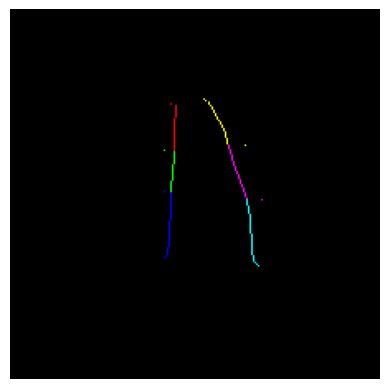

In [21]:
# boundary_mask=extract_colored_inner_lining(color_mask)
# def plot_image(image):

#     plt.imshow(image)  # Color image (3 channels)

#     plt.axis('off')  # Turn off axis labels
#     plt.show()

# plot_image(boundary_mask)

In [27]:
import numpy as np

color_masks = []     # To store (224, 224, 3) color masks
boundary_masks = []  # To store (224, 224, 3) boundary masks

for frame in video_matrix:
    if frame.max() <= 1.0:
        frame = (frame * 255).astype(np.uint8)

    color_mask = color_u_mask(frame)  # Shape: (224, 224, 3)
    boundary_mask = extract_colored_inner_lining(color_mask)  # Shape: (224, 224, 3)

    color_masks.append(color_mask)
    boundary_masks.append(boundary_mask)

# Convert lists to NumPy arrays of shape (num_frames, 224, 224, 3)
color_masks_array = np.stack(color_masks, axis=0)
boundary_masks_array = np.stack(boundary_masks, axis=0)

print("Color masks shape:", color_masks_array.shape)
print("Boundary masks shape:", boundary_masks_array.shape)

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
Color masks shape: (41, 224, 224, 3)
Boundary masks shape: (41, 224, 224, 3)


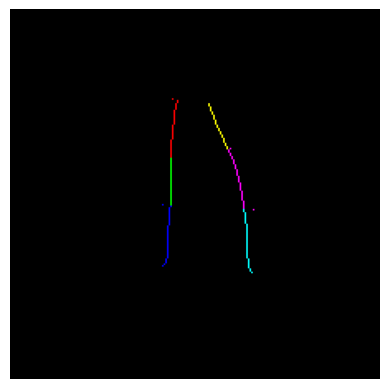

In [30]:
def plot_image(image):

    plt.imshow(image)  # Color image (3 channels)

    plt.axis('off')  # Turn off axis labels
    plt.show()

frame_index = 15  # Python is 0-indexed, so 10th frame is index 9
selected_boundary_mask = boundary_masks_array[frame_index]
plot_image(selected_boundary_mask)

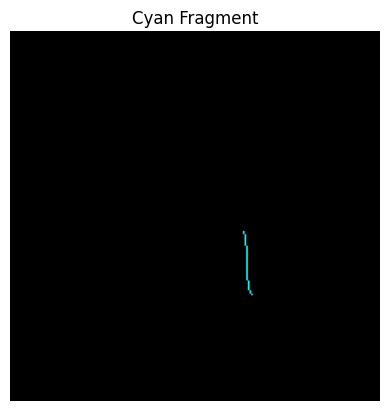

In [78]:
def extract_color_fragment(image_bgr, color='red'):
    """
    Extracts a specific color fragment from a BGR image.
    
    Parameters:
        image_bgr (np.ndarray): Input image in BGR format.
        color (str): Color to extract ('red', 'green', 'blue', etc.)

    Returns:
        np.ndarray: Masked image showing only the selected color fragment.
    """

    hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

    # Define color ranges in HSV
    color_ranges = {
        'red': [([100, 150, 0], [140, 255, 255])],
        'green': [([40, 50, 50], [80, 255, 255])],
        'blue': [([0, 100, 100], [10, 255, 255]),
                ([160, 100, 100], [180, 255, 255])],
        'yellow': [([85, 100, 100], [95, 255, 255])],
        'cyan': [([20, 100, 100], [30, 255, 255])],
        'magenta': [([140, 100, 100], [160, 255, 255])]
    }

    if color not in color_ranges:
        raise ValueError(f"Color '{color}' not supported. Choose from {list(color_ranges.keys())}.")

    masks = []
    for lower, upper in color_ranges[color]:
        lower_np = np.array(lower)
        upper_np = np.array(upper)
        mask = cv2.inRange(hsv, lower_np, upper_np)
        masks.append(mask)

    full_mask = masks[0]
    for m in masks[1:]:
        full_mask = cv2.bitwise_or(full_mask, m)

    result = cv2.bitwise_and(image_bgr, image_bgr, mask=full_mask)
    return result

# Example usage

fragment = extract_color_fragment(selected_boundary_mask, color='cyan')

# Convert to RGB for display
# fragment_rgb = cv2.cvtColor(fragment, cv2.COLOR_BGR2RGB)
# plt.imshow(fragment_rgb)
plt.imshow(fragment)
plt.axis('off')
plt.title('Cyan Fragment')
plt.show()


In [59]:
def fragment_to_binary_mask(fragment):
    """
    Converts a color fragment image to a binary mask.
    
    Parameters:
        fragment (np.ndarray): 3-channel BGR image where fragment pixels are non-zero.
    
    Returns:
        np.ndarray: Binary mask (single-channel) with 255 for fragment, 0 for background.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(fragment, cv2.COLOR_BGR2GRAY)
    # Threshold to get binary mask
    _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    return binary_mask
    
def get_uniform_points(mask, N=4):
    # Get coordinates of non-zero pixels (i.e., fragment)
    ys, xs = np.where(mask > 0)
    coords = np.column_stack((xs, ys))

    # Sort by arc length (e.g., left to right)
    coords = coords[np.lexsort((ys, xs))]

    # Uniformly sample N points
    if len(coords) < N:
        raise ValueError("Not enough points in mask to sample from.")

    indices = np.linspace(0, len(coords) - 1, N, dtype=int)
    return coords[indices]

def compute_displacement(reference_mask, target_mask, N=6):
    ref_points = get_uniform_points(reference_mask, N)
    tgt_points = get_uniform_points(target_mask, N)

    diffs = np.abs(ref_points - tgt_points)
    total_displacement = np.sum(diffs) / N
    return total_displacement

selected_boundary_mask1 = boundary_masks_array[0]
selected_boundary_mask2 = boundary_masks_array[1]

fragment1 = extract_color_fragment(selected_boundary_mask1, color='yellow')
fragment2 = extract_color_fragment(selected_boundary_mask2, color='yellow')

mask1 = fragment_to_binary_mask(fragment1)
mask2 = fragment_to_binary_mask(fragment2)

d_st = compute_displacement(mask1,mask2, N=6)
print(f"Average relative displacement: {d_st:.2f} pixels")

Average relative displacement: 2.50 pixels


In [60]:
print("hellow")

hellow


In [65]:
displacements = []  # This will store the displacement values

# Get the reference mask and its color fragment
reference_mask = boundary_masks_array[0]
reference_fragment = extract_color_fragment(reference_mask, color='yellow')
reference_binary = fragment_to_binary_mask(reference_fragment)

# Loop through each mask in the array
for i in range(len(boundary_masks_array)):
    current_mask = boundary_masks_array[i]
    current_fragment = extract_color_fragment(current_mask, color='yellow')
    current_binary = fragment_to_binary_mask(current_fragment)

    try:
        d_st = compute_displacement(reference_binary, current_binary, N=4)
    except ValueError:
        # Handle case where not enough points exist in the fragment
        d_st = np.nan  # Or you could set it to -1 or another flag
        print(f"Warning: Not enough points to compute displacement for index {i}")

    displacements.append(d_st)

# Convert to NumPy array
displacements = np.array(displacements)
print("All displacements relative to index 0:")
print(displacements)

All displacements relative to index 0:
[ 0.    2.75  1.5   2.5   6.5   9.25 13.25 12.25 15.5  13.25 12.   13.75
 10.75  7.5   7.25  8.    8.5   4.75  3.    1.25  4.25  1.    9.75  5.75
  7.25 10.75 12.75 11.25 13.75 13.5  11.    7.25 25.25  6.5   7.25  7.
  7.    5.75  2.25  3.75  7.  ]


In [63]:
print(len(displacements))

41


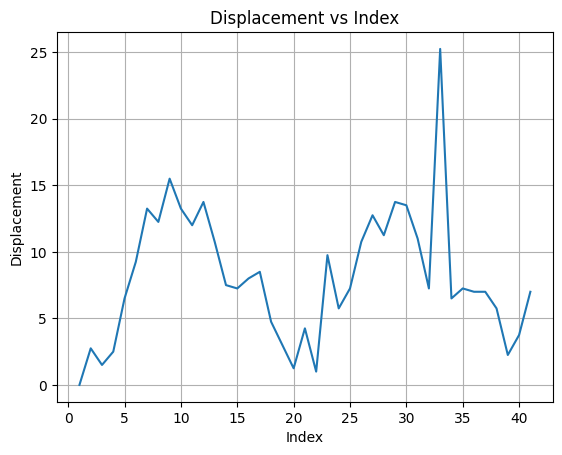

In [66]:
import matplotlib.pyplot as plt
import numpy as np

x_values = np.arange(1, 42)  

# Plotting the graph
plt.plot(x_values, displacements)

# Labeling the axes
plt.xlabel('Index')
plt.ylabel('Displacement')

# Title of the graph
plt.title('Displacement vs Index')

# Show the plot
plt.grid(True)
plt.show()

In [81]:
def compute_displacement_matrix(boundary_masks_array, colors, N=6):
    """
    Computes a displacement matrix for multiple color fragments across frames.

    Parameters:
        boundary_masks_array (list): List of masks (1 per frame).
        colors (list): List of color names (e.g., ['yellow', 'red', ...]).
        N (int): Number of points to sample per fragment.

    Returns:
        np.ndarray: A 2D array of shape (len(colors), len(boundary_masks_array))
    """
    num_colors = len(colors)
    num_frames = len(boundary_masks_array)
    displacements_matrix = np.zeros((num_colors, num_frames), dtype=np.float32)

    for c_idx, color in enumerate(colors):
        # Reference mask and fragment for the current color
        reference_mask = boundary_masks_array[0]
        reference_fragment = extract_color_fragment(reference_mask, color=color)
        reference_binary = fragment_to_binary_mask(reference_fragment)

        for i in range(num_frames):
            current_mask = boundary_masks_array[i]
            current_fragment = extract_color_fragment(current_mask, color=color)
            current_binary = fragment_to_binary_mask(current_fragment)

            try:
                d_st = compute_displacement(reference_binary, current_binary, N=N)
            except ValueError:
                d_st = np.nan
                print(f"Warning: Not enough points for color '{color}' in frame {i}")
            displacements_matrix[c_idx, i] = d_st

    return displacements_matrix

colors = ['red', 'green', 'blue','yellow', 'magenta','cyan']
displacement_matrix = compute_displacement_matrix(boundary_masks_array, colors, N=6)
print("Displacement matrix (rows: colors, cols: frames):")
print(displacement_matrix)

Displacement matrix (rows: colors, cols: frames):
[[ 0.        14.166667   4.1666665  4.5        7.8333335  8.5
  11.666667  12.        10.666667  14.5       12.        12.5
  15.833333  14.         4.8333335 16.166666  13.        17.166666
  12.166667  12.333333   6.6666665 12.666667  10.833333   9.333333
  11.166667  14.333333  12.        13.666667  10.666667  19.
   9.833333   5.6666665 22.166666   9.833333  14.166667   4.5
  13.         7.1666665 12.5       11.5        7.6666665]
 [ 0.        11.333333   8.        12.333333   8.666667  11.333333
  16.        15.166667  15.333333  15.166667  17.833334  15.666667
  16.333334  17.833334  11.5       16.        10.5       12.833333
  11.         9.5        9.166667  14.5       12.666667  11.666667
  12.        18.833334  18.5       16.5       16.333334  18.
  11.333333   8.166667  23.333334  18.5        5.8333335  8.833333
   4.        16.5       14.        15.833333  15.333333 ]
 [ 0.         1.8333334  8.333333   8.5       18.333334  

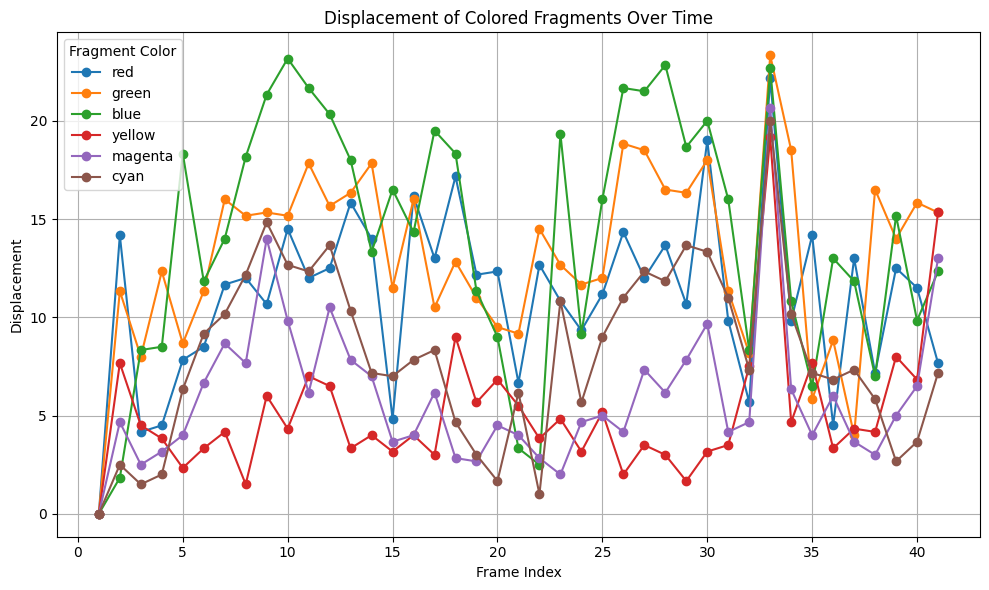

In [82]:
import matplotlib.pyplot as plt
import numpy as np

def plot_displacement_matrix(displacement_matrix, color_names, x_values=None):
    """
    Plots displacement curves for multiple color fragments on the same graph.

    Parameters:
        displacement_matrix (np.ndarray): 2D array of shape (num_colors, num_frames).
        color_names (list): List of color names corresponding to each row.
        x_values (array-like, optional): X-axis values (e.g., frame indices). If None, uses 1 to num_frames.
    """
    num_colors, num_frames = displacement_matrix.shape

    if x_values is None:
        x_values = np.arange(1, num_frames + 1)

    plt.figure(figsize=(10, 6))
    
    for i in range(num_colors):
        plt.plot(x_values, displacement_matrix[i], label=color_names[i], marker='o')

    plt.xlabel('Frame Index')
    plt.ylabel('Displacement')
    plt.title('Displacement of Colored Fragments Over Time')
    plt.legend(title='Fragment Color')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_displacement_matrix(displacement_matrix, colors)

Normalized displacement matrix:
[[0.         0.60714287 0.17857142 0.19285713 0.33571428 0.3642857
  0.5        0.5142857  0.45714286 0.62142855 0.5142857  0.53571427
  0.6785714  0.59999996 0.20714286 0.6928571  0.55714285 0.73571426
  0.5214286  0.5285714  0.28571427 0.54285717 0.4642857  0.39999998
  0.47857141 0.6142857  0.5142857  0.5857143  0.45714286 0.8142857
  0.42142856 0.24285713 0.9499999  0.42142856 0.60714287 0.19285713
  0.55714285 0.30714285 0.53571427 0.49285713 0.3285714 ]
 [0.         0.48571426 0.34285712 0.5285714  0.37142858 0.48571426
  0.68571424 0.65       0.6571428  0.65       0.76428574 0.67142856
  0.7        0.76428574 0.49285713 0.68571424 0.45       0.54999995
  0.47142857 0.40714285 0.39285713 0.62142855 0.54285717 0.5
  0.5142857  0.80714285 0.7928571  0.70714283 0.7        0.7714285
  0.48571426 0.35       1.         0.7928571  0.25       0.3785714
  0.17142856 0.70714283 0.59999996 0.6785714  0.6571428 ]
 [0.         0.07857143 0.35714284 0.3642857  0

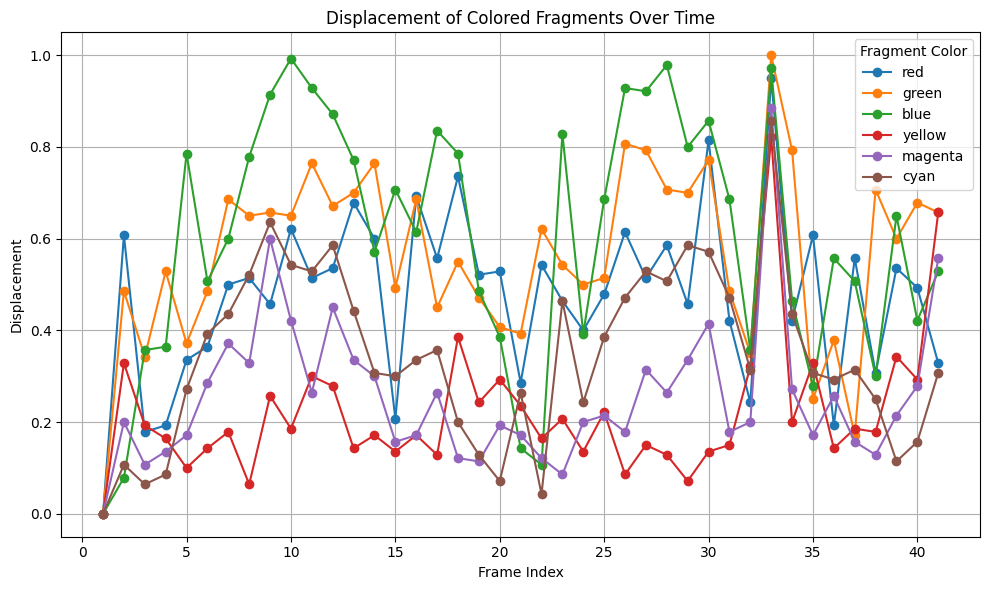

In [83]:
def normalize_displacement_matrix(displacement_matrix):
    max_val = np.nanmax(displacement_matrix)  # Use nanmax to ignore NaNs
    if max_val == 0 or np.isnan(max_val):
        raise ValueError("Maximum value is zero or NaN; cannot normalize.")

    return displacement_matrix / max_val

normalized_matrix = normalize_displacement_matrix(displacement_matrix)
print("Normalized displacement matrix:")
print(normalized_matrix)

plot_displacement_matrix(normalized_matrix, colors)

In [1]:
import cv2

# Replace with the path to your .avi file
video_path = '/kaggle/input/myocardial-infarction/HMC-QU Dataset-Kaggle/HMC-QU/A4C/ES000137_4CH_1.avi'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Cannot open video file.")
else:
    # Get the total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total number of frames: {total_frames}")

# Release the video capture object
cap.release()

Total number of frames: 19
